# NPL and classification models 

Fit the model using pipeline and then gridsearch for best parameters. The goal is to find models with highest accuracy, if comparable, find the most generalizing model.

* **NPL:** CounterVectorizer
* **Classification models:** RandomForest, MultinomialNB(generally perfect for NPL), AdaBoost, SVC, Votingclassfier

Votingclassifier was used to vote on the two best performing models: Randomforest and MultinomialNB.

In [155]:
#import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC


from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Load pre-processed data

In [156]:
#load pre-processed data
combine=pd.read_csv('./datasets/subreddit_title.csv')
combine

,title,subreddit,title_word_count
0,Can I work here two days a week or should I pu...,wholefoods,16
1,John Mackey and Andy Jassy need to watch this ...,wholefoods,10
2,This is how entitled customers are,wholefoods,6
3,How to correct a punch in Krono?,wholefoods,7
4,Ridiculously Complex and Ambiguous Assessment ...,wholefoods,6
...,...,...,...
1995,New BBQ 101 smells great! Let’s see how it is ...,traderjoes,14
1996,"Naturally, I'm confused.",traderjoes,4
1997,Small TJ’s haul!,traderjoes,4
1998,The Great Chocolate Mochi Cake Reenactment,traderjoes,6


### Check null model

In [157]:
combine['subreddit'].value_counts(normalize=True)

wholefoods    0.5
traderjoes    0.5
Name: subreddit, dtype: float64

* The null model: If we take a guess, we should have 50% chance of accuracy by default.

## Create X features and target variable y

In [158]:
X=combine['title']
y=combine['subreddit']

## Split to train and test datatests

In [159]:
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, stratify=y)

## Define functions for Pipeline, GridSearchCV and Plot confusion matrix

#### 1. Define a function to take an estimator create a pipeline for CountVectorizer

In [160]:
# define pipeline
def cv_pipeline(estimator):
    pipe=Pipeline([
    ('cv',CountVectorizer(min_df=2)),#this is modified after seeing min_df=2 is better for most of model from grid_search to save compute time
    ('e', estimator)
])
    pipe.fit(X_train, y_train)
    print(f'train score: {pipe.score(X_train, y_train)}')
    print(f'test score:{pipe.score(X_test, y_test)}')
    return pipe

#### 2. define a function to take an estimator, grid parameters

In [161]:
#define a function to grid search on a given pipeline estimator and grid params
def grid_search(pipe, params):
    gd=GridSearchCV(estimator=pipe, param_grid=params, verbose=1)
    gd.fit(X_train, y_train)
    print(f'gridsearch train score: {gd.score(X_train, y_train)}.\ngridsearch test score: {gd.score(X_test, y_test)}.')
    print(f'gridsearch best parameters: {gd.best_params_}')
    return gd

#### 3. define a function to plot confusion matrix for an given estimator

In [162]:
#define a function to plot confusion matrix for an given estimator
def plot_confusion_matrix(estimator):
    'This function should only be used on a fited model'
    cm=confusion_matrix(y_true=y_test, y_pred=estimator.predict(X_test))
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
    disp.plot()

## Modeling Screening

* 4 Models have been explored:
1. Random Forest Classifier
2. MultinomialNB
3. AdaBoost Classifier
4. SVM model

**The objective is to find the best model with the highest accuracy and a good generalizing model**

After comparing the fit score, a votingclassifier was done on the two comparable models with distinct recall scores:
* Random Forest Classifier vs. MultinomialNB

### 1. Randomforest classifier pipeline

In [163]:
#instantiate a random forest classifier
rfc=RandomForestClassifier(random_state=42)

#call the rfc_pipe function
rfc_pipe=cv_pipeline(rfc)

train score: 0.9966666666666667
test score:0.882


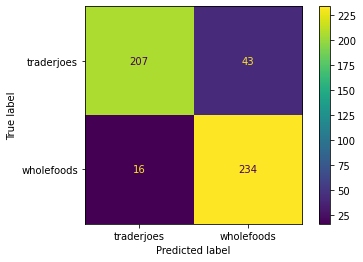

In [177]:
plot_confusion_matrix(rfc_pipe)

#### Gridsearch over randomforest classifier

In [164]:
params={
    'cv__min_df':[1,2],
    'e__n_estimators':[100,500,700],
    'e__min_samples_split':[3,5,7],
    'e__ccp_alpha':np.linspace(0.00001,1,20)
}

In [165]:
rfc_gd=grid_search(rfc_pipe, params)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
gridsearch train score: 0.9893333333333333.
gridsearch test score: 0.878.
gridsearch best parameters: {'e__ccp_alpha': 1e-05, 'e__min_samples_split': 7, 'e__n_estimators': 700}


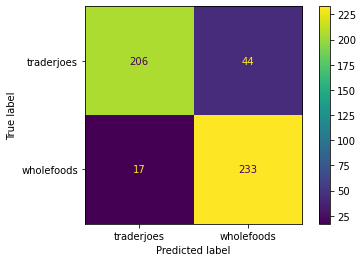

In [166]:
plot_confusion_matrix(rfc_gd)

### 2. MultinomialNB pipeline

In [167]:
#instantiate a multinomialNB object
mnb=MultinomialNB()

mnb_pipe=cv_pipeline(mnb)

train score: 0.9526666666666667
test score:0.884


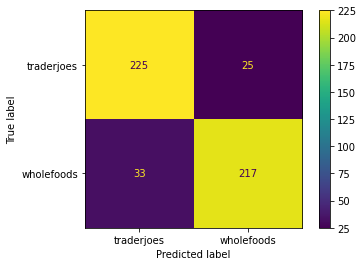

In [168]:
plot_confusion_matrix(mnb_pipe)

#### Gridsearch over multinomialNB pipeline

In [182]:
params={
    'cv__min_df':[1,2],
    'cv__ngram_range':[(1,1)],
    'cv__max_features':[None,8,30]
}

In [183]:
mnb_gd=grid_search(mnb_pipe, params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
gridsearch train score: 0.9786666666666667.
gridsearch test score: 0.888.
gridsearch best parameters: {'cv__max_features': None, 'cv__min_df': 1, 'cv__ngram_range': (1, 1)}


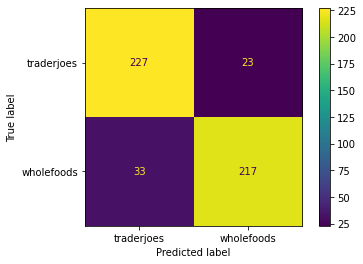

In [184]:
plot_confusion_matrix(mnb_gd)

### 3. AdaBoostClassifier pipeline

In [172]:
abc=AdaBoostClassifier()
abc_pipe=cv_pipeline(abc)

train score: 0.878
test score:0.826


In [175]:
params={
    'cv__min_df':[1,2],
    'cv__ngram_range':[(1,1),(1,2)],
    'cv__max_features':[None, 3, 5],
    'e__n_estimators':[50, 150, 200]
}

#### Gridsearch over AdaBoostClassifier pipeline

In [176]:
abc_grid=grid_search(abc_pipe, params)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
gridsearch train score: 0.9566666666666667.
gridsearch test score: 0.842.
gridsearch best parameters: {'cv__max_features': None, 'cv__min_df': 1, 'cv__ngram_range': (1, 2), 'e__n_estimators': 150}


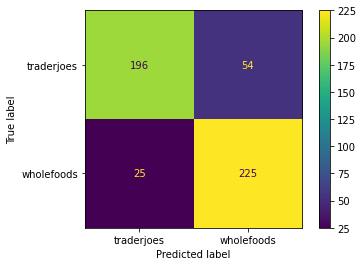

In [185]:
plot_confusion_matrix(abc_grid)

### 4. SVM model

In [186]:
svc=SVC()
svc_pipe=cv_pipeline(svc)

train score: 0.96
test score:0.85


In [187]:
params={
    'cv__min_df':[1,2],
    'cv__ngram_range':[(1,1),(1,2)],
    'cv__max_features':[None, 3, 5],
    'e__C':np.linspace(1,10,20),
    'e__kernel':['poly', 'rbf', 'sigmoid'],
    'e__degree':[2,3,4]
}

#### Gridsearch over SVC pipeline

In [188]:
svc_grid=grid_search(svc_pipe, params)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
gridsearch train score: 0.994.
gridsearch test score: 0.856.
gridsearch best parameters: {'e__C': 3.8421052631578947, 'e__degree': 2, 'e__kernel': 'rbf'}


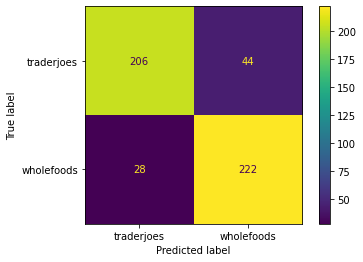

In [189]:
plot_confusion_matrix(svc_grid)

## VotingClassifier on two models with comparable accuracy score
* Random Forest Classifier and MultinominalNB

In [190]:
from sklearn.ensemble import VotingClassifier

In [191]:
cv=CountVectorizer(min_df=2)
X_train_cv=cv.fit_transform(X_train)
X_test_cv=cv.transform(X_test)


In [192]:
rfc_best=RandomForestClassifier(n_estimators=500, ccp_alpha=1e-05, min_samples_split=5, random_state=42)
mnb=MultinomialNB()

In [193]:
vc=VotingClassifier(estimators=[('rfc',rfc_best), ('mnb',mnb)], voting='soft')

In [194]:
vc.fit(X_train_cv, y_train)
vc.score(X_train_cv, y_train), vc.score(X_test_cv, y_test)

(0.9766666666666667, 0.898)

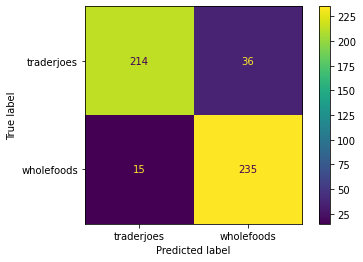

In [195]:
#define a function to plot confusion matrix for an given estimator
def plot_confusion_matrix_1(estimator):
    'This function should only be used on a fited model'
    cm=confusion_matrix(y_true=y_test, y_pred=estimator.predict(X_test_cv))
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
    disp.plot()
    
plot_confusion_matrix_1(vc)

### Classification report on votingclassifier, muntinomialNB and randomforest classifier

In [196]:
print(classification_report(y_test, vc.predict(X_test_cv)))

              precision    recall  f1-score   support

  traderjoes       0.93      0.86      0.89       250
  wholefoods       0.87      0.94      0.90       250

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



In [201]:
print(classification_report(y_test, mnb_gd.predict(X_test)))

              precision    recall  f1-score   support

  traderjoes       0.87      0.91      0.89       250
  wholefoods       0.90      0.87      0.89       250

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



In [200]:
print(classification_report(y_test, rfc_pipe.predict(X_test)))

              precision    recall  f1-score   support

  traderjoes       0.93      0.83      0.88       250
  wholefoods       0.84      0.94      0.89       250

    accuracy                           0.88       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.89      0.88      0.88       500



### Final model performance summary

**Votingclassfier further improved the accuracy from 0.88 to 0.90**

||Accuracy|Precision|Recall(pos=traderjoes)|
|---|---|---|---|
|**VotingClassifier**|0.9|0.93|0.86|
|**MultinomialNB**|0.88|0.87|0.9|
|**RandomForestClassifier**|0.88|0.93|0.83|


**Model recommendation should be tailored to customer need:**
* If the customer cares the total correctly prediction for both stores, VotingClassifier is recommended.
* If my customer cares more accurate prediction on Trader Joe's posts, in other word, a higher recall score for Trader Joes, Multinomial NB model is recommended.

In [2]:
vc.predict(['I am crave for cheap organic produce!'])

NameError: name 'vc' is not defined

In [1]:
import pickle

In [3]:
with open('predict_reddit.pkl', mode='wb') as pickle_out:
    pickle.dump(vc, pre_dict_reddit.pkl)

NameError: name 'vc' is not defined